In [87]:
pwd

u'/Users/abrahamn/Documents/MIT/21cm/21cmIR/21cmIRxcor/3Dsensitivitycalculations'

In [71]:
import sys
sys.path.insert(0, '/Users/abrahamn/21cmIR/21cmIRxcor/')
import mwa_utils

In [72]:
import pickle
import numpy as np
from numpy import pi
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [73]:
# MWA uv space sampling
analysis_root = '/Volumes/abraham/xcor_data/analysis/21cmfreqavgcubes/'
fhddeeplabel = 'Combined_obs_wedge_cut_plus_res_cut'
mwa_deep_image = pickle.load( open( analysis_root+fhddeeplabel+'.p', "rb" ) )

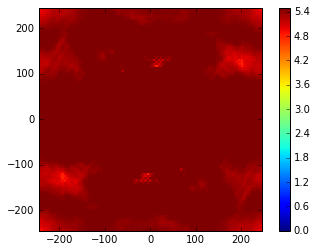

In [74]:
# the total obs time in each uv cell is proportional to weights_uv
weights_uv = np.abs(np.fft.fft2(mwa_deep_image.weights_xx0))

#t_hours = 3.
t_hours = 500.
t_obs_21_sec = t_hours*3600.

Nant = 112 # 128 MWA ants minus 16 outriggers
num_baselines = Nant*(Nant-1)/2
num_seconds_per_uv = weights_uv/np.sum(weights_uv)*np.sum(num_baselines*t_obs_21_sec)

lamda = 300./185
du = 1./(mwa_deep_image.n*mwa_deep_image.dtheta_rad)
umax = du*mwa_deep_image.n/2

plt.imshow(np.log10(np.fft.fftshift(num_seconds_per_uv)),interpolation='nearest',vmin=0,vmax=5.5,extent=[-umax,umax,-umax,umax])
plt.colorbar()

In [75]:
# cosmology
from cosmocalc import cosmocalc
WM,WV = 0.27,0.73
c = 3.e8
h = 6.626e-34 # J*sec
c_over_H0_Mpc = 4283.

In [76]:
# experimental params
z = 7.
Deltaz = .5

Ez = np.sqrt(WM*(1+z)**3+WV)

D = cosmocalc(z,WM=WM,WV=WV)['DCMR_Mpc']
DeltaD = c_over_H0_Mpc*Deltaz/Ez
wedgeslope = D*Ez/(c_over_H0_Mpc*(1+z))*(pi/2)

In [77]:
# perp sampling
theta_fov_rad = mwa_deep_image.n*mwa_deep_image.dtheta_rad
dtheta_rad = mwa_deep_image.dtheta_rad
Nperp = mwa_deep_image.n

In [78]:
# 21cm expt
f0_21_Hz = 1420.e6
B_Hz = Deltaz*f0_21_Hz/(1+z)**2
df = 40.e3
Nf = int(B_Hz/df)

In [79]:
dkpara = 2.*pi/DeltaD
kparamax = Nf/2*dkpara

dkperp = 2.*pi/(theta_fov_rad*D)
kperpmax = Nperp/2*dkperp

kparavals = np.fft.fftfreq(Nf)*Nf*dkpara
kperpvals = np.fft.fftfreq(Nperp)*Nperp*dkperp
kzgrid,kxgrid,kygrid = np.meshgrid(kparavals,kperpvals,kperpvals,indexing='ij')

kperpgrid = np.sqrt(kxgrid**2+kygrid**2)
kmaggrid = np.sqrt(kxgrid**2+kygrid**2+kzgrid**2)
inwindow = kzgrid > wedgeslope*kperpgrid

In [80]:
# 21cm thermal noise
# https://www.evernote.com/shard/s316/nl/2147483647/6f7c9ac4-f872-407d-89e3-acb8fdff1982/
    
Tsky_K = 400.
A_21 = 20. # m^2
B_Hz = 30.e6 # MHz
P_21_thermal = (Tsky_K**2)*(lamda**2)*(D**2)*DeltaD/(B_Hz*A_21)/num_seconds_per_uv

P_21_thermal_veck = np.repeat([P_21_thermal],Nf,axis=0)

In [81]:
def bin_noise_to_1D(P1_veck,P2_veck,nbins=5,kmax=.1,wedgecut=False):
    kbinedges = np.linspace(0,kmax,nbins+1)
    kbincenters = .5*(kbinedges[0:nbins]+kbinedges[1:nbins+1])

    P_binned = np.zeros(nbins)
    P_binned_wedgecut = np.zeros(nbins)
    bin_counts = np.zeros(nbins)
    for bini in range(nbins):
        inbin = (kmaggrid>kbinedges[bini])&(kmaggrid<kbinedges[bini+1])
        if wedgecut: inbin &= inwindow
    
        bin_counts[bini] = np.sum(inbin)
        P_binned[bini] = np.sqrt(1./(np.sum( 1./(P1_veck[inbin]*P2_veck[inbin]) )))
        
    return kbincenters,P_binned,bin_counts

In [82]:
# load vanilla 21cmFAST power spectrum from Pober 14 (what can 21cm observatories teach us about reionization?)
poberdat = np.genfromtxt('pober_21cm_model_pspec_vanilla_z=8.csv',delimiter=',')
pober_k = poberdat[:,0]
pober_Delta_K = np.sqrt(poberdat[:,1])*1.e-3

In [83]:
# load the beardsley EOR theory curve
print(open('beardsley_eor_theory.csv').readlines()[:2])
beardsleydat = np.genfromtxt('beardsley_eor_theory.csv',delimiter=',')
beardsley_eor_k = beardsleydat[:,0]
T0 = 26.e-3
DeltaSquared_beardsley_eor = beardsleydat[:,1]*T0**2

['# k, Delta^2 (mK)\n', "# big blue points in Fig. 4 of Adam's sensitivity paper\n"]


In [84]:
# load the beardsley MWA sensitivity calculations
print(open('beardsley_MWA_450hour_sensitivity.csv').readlines()[:2])
beardsleymwadat = np.genfromtxt('beardsley_MWA_450hour_sensitivity.csv',delimiter=',')
beardsley_mwa_k = beardsleymwadat[:,0]
DeltaSquared_beardsley_mwa = beardsleymwadat[:,1]*T0**2

['# k, Delta^2 (mK)\n', "# green line in Fig. 4 of Adam's sensitivity paper\n"]


(0.01, 20)

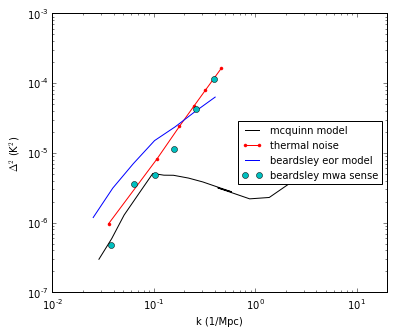

In [85]:
# what about auto spectra sensitivity?

kbincenters,P_21_binned,bin_counts = bin_noise_to_1D(P_21_thermal_veck,P_21_thermal_veck,7,.5,wedgecut=False)

plt.figure(figsize=(6,5))

plt.loglog(pober_k,pober_Delta_K**2,'k-',label='mcquinn model')
plt.loglog(kbincenters,kbincenters**2/(2*pi**2)*P_21_binned,'r.-',label='thermal noise')
plt.loglog(beardsley_eor_k,DeltaSquared_beardsley_eor,'b-',label='beardsley eor model')
plt.loglog(beardsley_mwa_k,DeltaSquared_beardsley_mwa,'co',label='beardsley mwa sense')
plt.legend(fontsize=10,loc=5)
plt.xlabel('k (1/Mpc)')
plt.ylabel(r'$\Delta^2$ (K$^2$)')
plt.xlim([.01,20])

In [86]:
kbincenters

array([ 0.03571429,  0.10714286,  0.17857143,  0.25      ,  0.32142857,
        0.39285714,  0.46428571])